In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [33]:
import webdataset as wds
figsize(20, 10)

dict_keys(['__key__', 'png', 'probs.png', 'words.png'])


0.99607843

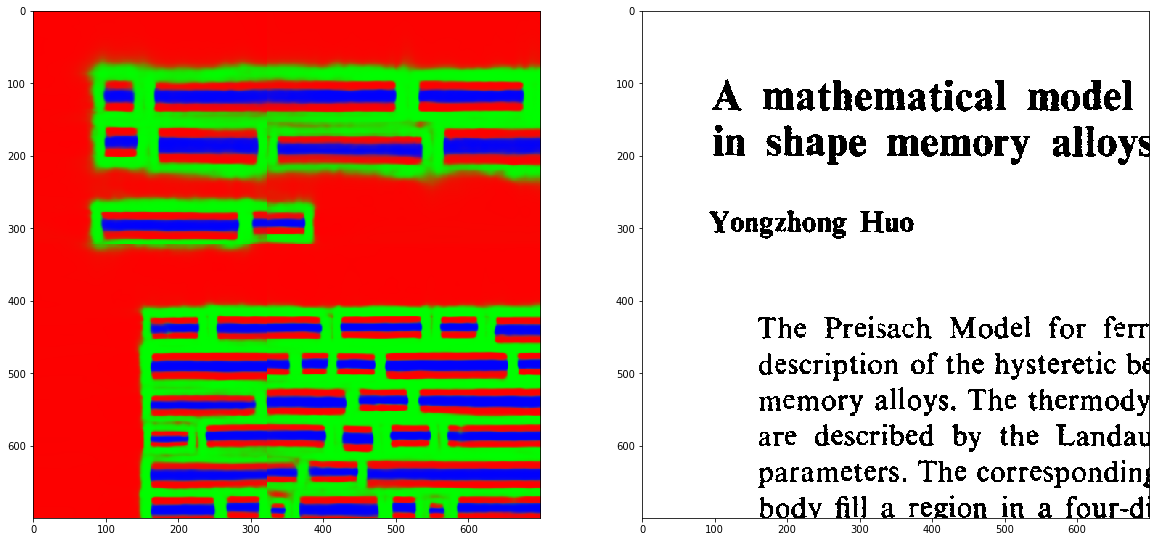

In [78]:
dataset = wds.WebDataset("out.tgz")
sample = next(iter(dataset))
print(sample.keys())
sub = (slice(700, 1400), slice(700, 1400))
probs = sample["probs.png"][sub]
image = sample["png"][sub]
subplot(121); imshow(probs); subplot(122); imshow(image)
amax(probs)

In [79]:
import scipy.ndimage as ndi
from ocrlib import psegutils
from itertools import islice
def pad_slice(sl, r):
    if isinstance(r, int):
        return slice(max(sl.start-r, 0), sl.stop+r)
    elif isinstance(r, float):
        d = int((0.5+sl.stop-sl.start)*r)
        return slice(max(sl.start-d, 0), sl.stop+d)
    else:
        raise ValueError(f"range {r}")

38

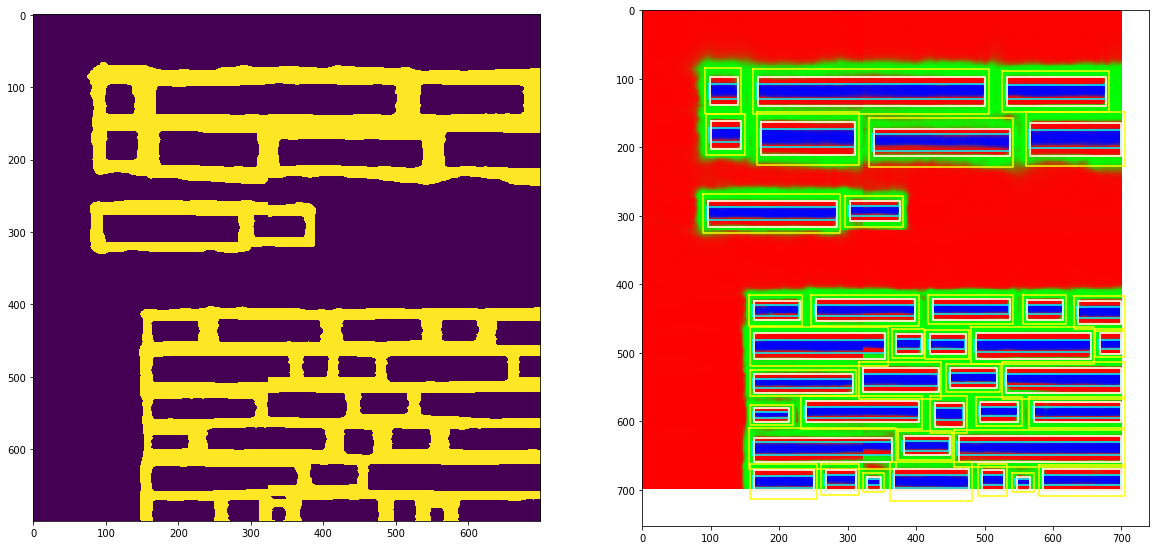

In [131]:
def pad_slice(sl, r):
    """Pad a slice by #pixels (r>=1) or proportionally (0<r<1)."""
    return slice(max(sl.start-r, 0), sl.stop+r)

def dilate_slice(sl, r):
    """Dilate a slice by `r` around its center."""
    center = (sl.start+sl.stop) / 2.0
    width = sl.stop - sl.start
    return slice(int(max(center-width*r/2.0, 0)), int(center+width*r/2.0))

def intersect_slices(s1, s2):
    lo = max(s1.start, s2.start)
    hi = min(s1.stop, s2.stop)
    return slice(lo, max(hi, lo))

def intersect_boxes(b1, b2):
    return [intersect_slices(s1, s2) for s1, s2 in zip(b1, b2)]

def box_area(box):
    return prod([s.stop-s.start for s in box])

def plot_box(b, **kw):
    ys, xs = b[:2]
    y0, y1, x0, x1 = ys.start, ys.stop, xs.start, xs.stop
    plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0], **kw)

def plot_boxes(boxes, **kw):
    for b in boxes:
        plot_box(b, **kw)

def extract_segments(probs, maxheight=3.0, hpad=5, show=False, vclose=0, hclose=10):
    markers = psegutils.hysteresis_threshold(probs[:,:,2], 0.3, 0.7)
    separators = psegutils.hysteresis_threshold(probs[:,:,1], 0.3, 0.7)
    if hclose > 0:
        separators = ndi.minimum_filter(ndi.maximum_filter(separators, (1, hclose)), (1, hclose))
    if vclose > 0:
        separators = ndi.minimum_filter(ndi.maximum_filter(separators, (vclose, 1)), (vclose, 1))
    word_labels, n = ndi.label(markers)
    segment_labels, n = ndi.label(1-clip(separators, 0, 1))
    seg2word = {s: w for s, w in psegutils.correspondences(segment_labels, word_labels).T}
    if show:
        subplot(121)
        #imshow((word_labels>0)*(0.5+0.5*sin(5.0*word_labels)**2), cmap=cm.inferno)
        #imshow((segment_labels>0)*(0.5+0.5*sin(5.0*segment_labels)**2), cmap=cm.inferno)
        imshow(separators)
        subplot(122)
        imshow(probs)
    word_boxes = [(slice(0,0), slice(0,0))] + ndi.find_objects(word_labels)
    result = []
    for i, seg_box in enumerate(ndi.find_objects(segment_labels)):
        label = i+1
        wlabel = seg2word.get(label, 0)
        if wlabel==0: continue
        wh, ww = word_box = word_boxes[wlabel]
        outer_box = (dilate_slice(wh, 3), pad_slice(ww, 5))
        final = intersect_boxes(outer_box, seg_box)
        if box_area(final) < 10: continue
        if show:
            plot_box(seg_box, color="orange")
            plot_box(word_box, color="cyan")
            plot_box(outer_box, color="yellow")
            plot_box(final, color="white")
        result.append(tuple(final))
    return result

boxes = extract_segments(probs, show=True)
len(boxes)

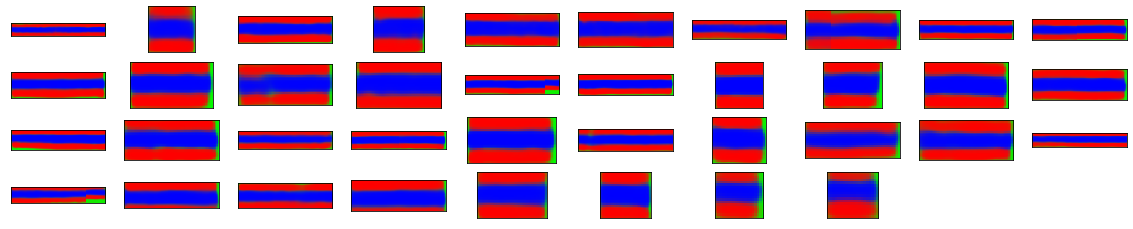

In [132]:
for i, b in enumerate(boxes[:100]):
    subplot(10, 10, i+1); xticks([]); yticks([])
    imshow(probs[b])

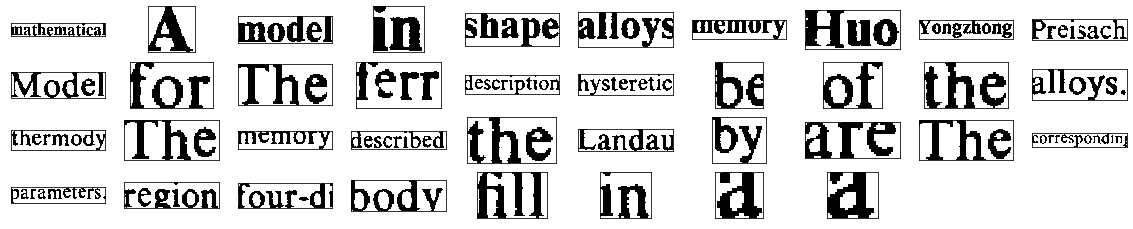

In [133]:
for i, b in enumerate(boxes[:50]):
    subplot(10, 10, i+1); xticks([]); yticks([])
    imshow(image[b])